In [69]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# 生成示例数据
np.random.seed(0)
T = 5000  # 时间序列长度
time = np.arange(0, T, 1)
temperature = 20 + 10 * np.sin(2 * np.pi * time / 365) + np.random.normal(0, 2, T)


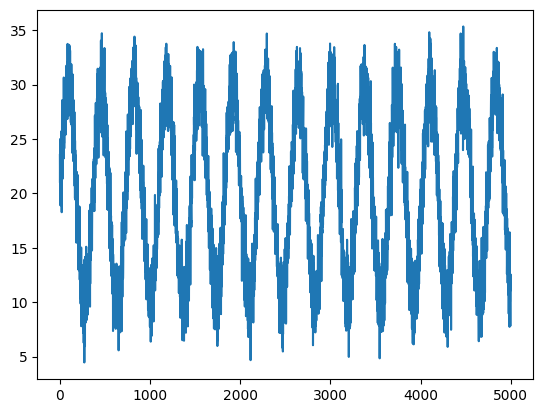

In [70]:
import matplotlib.pyplot as plt

plt.plot(time, temperature)

In [71]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import math

# 准备数据
def prepare_data(data, seq_length):
    input_data, target = [], []
    for i in range(len(data) - seq_length):
        input_data.append(data[i:i+seq_length])
        target.append(data[i+seq_length])
    return input_data, target

# 定义序列长度和训练集大小
seq_length = 10
train_size = int(0.8 * len(temperature))

# 准备训练集和测试集数据
train_data, train_target = prepare_data(temperature[:train_size], seq_length)
test_data, test_target = prepare_data(temperature[train_size:], seq_length)

# 转换数据为PyTorch张量
train_data = torch.tensor(train_data).float()
train_target = torch.tensor(train_target).float()
test_data = torch.tensor(test_data).float()
test_target = torch.tensor(test_target).float()

class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=10):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

class TransAm(nn.Module):
    def __init__(self, feature_size=10, num_layers=1, dropout=0.1):
        super(TransAm, self).__init__()
        self.model_type = 'Transformer'

        self.src_mask = None
        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=10, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(feature_size,1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self,src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.pos_encoder(src)
        output = self.transformer_encoder(src,self.src_mask)
        output = self.decoder(output)
        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

In [72]:
temperature[:11]

array([23.52810469, 20.97244798, 22.30169208, 24.99798307, 24.42314025,
       18.90509223, 22.93119381, 20.89936603, 21.16635002, 22.36428521,
       22.00101858])

In [73]:
train_data[0]

tensor([23.5281, 20.9724, 22.3017, 24.9980, 24.4231, 18.9051, 22.9312, 20.8994,
        21.1663, 22.3643])

In [74]:
train_target[0]

tensor(22.0010)

In [75]:
# 定义模型参数
d_model = 32
max_seq_len = seq_length
num_heads = 4
num_layers = 2

# 创建模
model = TransAm()#TransformerModel(d_model, max_seq_len, num_heads, num_layers)
enc_features_size = 10
dec_features_size = 1
#model = TransformerTS(enc_features_size, enc_features_size)
# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
batch_size = 32 #150
# 迭代训练数据
num_epochs = 200
for epoch in range(num_epochs):
    # 在每个epoch之前初始化损失累计
    total_loss = 0.0
    
    for i in range(0, len(train_data), batch_size):
        # 获取一个batch的训练数据
        batch_inputs = train_data[i:i+batch_size]
        batch_labels = train_target[i:i+batch_size]
        
        # 清零梯度
        optimizer.zero_grad()
        
        # 前向传播
        outputs = model(batch_inputs)
        
        # 计算损失
        loss = criterion(outputs, batch_labels)
        
        # 反向传播和优化
        loss.backward()
        optimizer.step()
        
        # 累计损失
        total_loss += loss.item()
    
    # 打印每个epoch的平均损失
    avg_loss = total_loss / (len(train_data) // batch_size)
    if epoch%20==0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

/Users/yukaisun/opt/anaconda3/envs/tabpfn/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([10, 32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yukaisun/opt/anaconda3/envs/tabpfn/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([22])) that is different to the input size (torch.Size([10, 22, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/200, Loss: 410.3200
Epoch 21/200, Loss: 16.7386
Epoch 41/200, Loss: 11.0201
Epoch 61/200, Loss: 9.6126
Epoch 81/200, Loss: 9.4233
Epoch 101/200, Loss: 8.7558
Epoch 121/200, Loss: 8.4888
Epoch 141/200, Loss: 8.0677
Epoch 161/200, Loss: 8.2874
Epoch 181/200, Loss: 7.8158


In [83]:
with torch.no_grad():
    model.eval()
    test_output = model(test_data)
print(criterion(test_output[0], test_target))

tensor(104.1224)


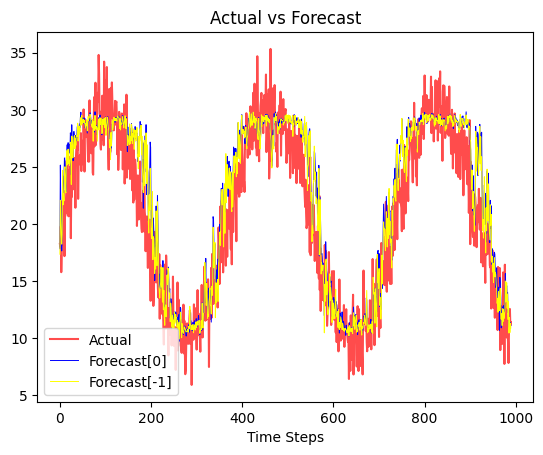

In [85]:
plt.plot(test_target, color='red', alpha=0.7)
plt.plot(test_output[0], color='blue', linewidth=0.7)
plt.plot(test_output[-1], color='yellow', linewidth=0.7)

plt.title('Actual vs Forecast')
plt.legend(['Actual', 'Forecast[0]', 'Forecast[-1]'])
plt.xlabel('Time Steps')
plt.show()

### 2 - 

In [1]:
import tqdm
import pandas as pd
import numpy as np
from tqdm import tqdm, notebook
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch import optim
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from torch.utils.data import DataLoader

In [4]:
# 准备数据
def prepare_data(data, seq_length):
    input_data, target = [], []
    for i in range(len(data) - seq_length):
        input_data.append(data[i:i+seq_length])
        target.append(data[i+seq_length])
    return input_data, target

# 定义序列长度和训练集大小
seq_length = 10
train_size = int(0.8 * len(temperature))

# 准备训练集和测试集数据
train_data, train_target = prepare_data(temperature[:train_size], seq_length)
test_data, test_target = prepare_data(temperature[train_size:], seq_length)

seq_length = 10

traindf = prepare_data(temperature[:train_size], seq_length)
testdf = prepare_data(temperature[train_size:], seq_length)


print(len(train_data))
for i, j in zip(train_data, train_target):
    print(temperature[:11])
    print(i)
    print(j)
    break

trainX = torch.tensor(traindf[0]).float()
trainy = torch.tensor(traindf[1]).float()
testX = torch.tensor(testdf[0]).float()
testy = torch.tensor(testdf[1]).float()

3990
[23.52810469 20.97244798 22.30169208 24.99798307 24.42314025 18.90509223
 22.93119381 20.89936603 21.16635002 22.36428521 22.00101858]
[23.52810469 20.97244798 22.30169208 24.99798307 24.42314025 18.90509223
 22.93119381 20.89936603 21.16635002 22.36428521]
22.00101858413653


/var/folders/s1/w69x8mm13wz_1npk05p7rzy00000gn/T/ipykernel_88719/2155229121.py:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  trainX = torch.tensor(traindf[0]).float()


In [10]:
#from torch.utils.data import Dataset

class TSDataset:
  def __init__(self, data, label=None):
    self.data = data
    self.label = label
    #print(data)
  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    sequence, label = self.data[idx], self.label[idx]

    return dict(
        sequence=sequence,
        label=label)

In [32]:
import pytorch_lightning as pl

class TSDataModule(pl.LightningDataModule):
  def __init__(self, trainX, trainy, testX, testy, batch_size=32):
    super().__init__()
    self.trainX = trainX
    self.trainy = trainy
    self.testX = testX
    self.testy = testy
    self.batch_size = batch_size

  def setup(self, stage=None):
    self.train_dataset = TSDataset(self.trainX, self.trainy)
    self.test_dataset = TSDataset(self.testX, self.testy)

  def train_dataloader(self):
    return DataLoader(
        self.train_dataset,
        batch_size=self.batch_size,
        shuffle=False,
        num_workers=0)

  def test_dataloader(self):
    return DataLoader(
        self.test_dataset,
        batch_size=1,
        shuffle=False,
        num_workers=0)

In [33]:
N_EPOCHS = 500
BATCH_SIZE = 32

data_module = TSDataModule(trainX, trainy, testX, testy, batch_size=BATCH_SIZE)
data_module.setup()

In [34]:
X = TSDataset(data=trainX, label=trainy)

In [35]:
for i in Ｘ:
    print(i['label'])
    print(i['sequence'])
    break

tensor(22.0010)
tensor([23.5281, 20.9724, 22.3017, 24.9980, 24.4231, 18.9051, 22.9312, 20.8994,
        21.1663, 22.3643])


In [36]:
class TSPredictModel(nn.Module):
  def __init__(self, n_features, n_hidden=128, n_layers=2):
    super().__init__()
    self.n_hidden = n_hidden
    self.lstm = nn.LSTM(
        input_size = n_features,
        hidden_size = n_hidden,
        batch_first = True,
        num_layers = n_layers,
        dropout=0.2)
    self.regressor = nn.Linear(n_hidden, 1)

  def forward(self, x):
    self.lstm.flatten_parameters()
    _, (hidden, _) = self.lstm(x)
    out = hidden[-1]
    return self.regressor(out)

In [42]:
class TSPredictor(pl.LightningModule):
  def __init__(self, n_features: int):
    super().__init__()
    self.model = TSPredictModel(n_features)
    self.criterion = nn.MSELoss()

  def forward(self, x, labels=None):
    output = self.model(x)
    loss = 0
    if labels is not None:
      loss = self.criterion(output, labels.unsqueeze(dim=1))
    return loss, output

  def training_step(self, batch, batch_idx):
    sequences = batch['sequence']
    labels = batch['label']

    loss, output = self(sequences, labels)
    self.log('train_loss', loss, prog_bar=True, logger=True)
    return loss
  
  def validation_step(self, batch, batch_idx):
    sequences = batch['sequence']
    labels = batch['label']

    loss, output = self(sequences, labels)
    self.log('val_loss', loss, prog_bar=True, logger=True)
    return loss

  def test_step(self, batch, batch_idx):
    sequences = batch['sequence']
    labels = batch['label']

    loss, output = self(sequences, labels)
    self.log('test_loss', loss, prog_bar=True, logger=True)
    return loss

  def configure_optimizers(self):
    return optim.AdamW(self.parameters(), lr=0.0001)

In [43]:
trainX.shape

torch.Size([3990, 10])

In [44]:
model = TSPredictor(n_features=trainX.shape[1])

In [62]:
#from lightning_fabric.loggers import TensorBoardLogger
checkpoint_callback = ModelCheckpoint(
    dirpath = 'checkpoints',
    filename = 'best-checkpoint',
    save_top_k = 1,
    verbose=True,
    monitor = 'train_loss',
    mode = 'min'
) 

logger = TensorBoardLogger('lightning_logs', name='btc-price')

early_stopping_callback = EarlyStopping(monitor='train_loss', patience=2)

trainer = pl.Trainer(
    logger = logger,
    callbacks=[checkpoint_callback, early_stopping_callback],
    max_epochs = 5000,#N_EPOCHS,
    #gpus=1,
    accelerator="auto"
    #progress_bar_refresh_rate=30
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [63]:
trainer.fit(model, data_module)


  | Name      | Type           | Params
---------------------------------------------
0 | model     | TSPredictModel | 203 K 
1 | criterion | MSELoss        | 0     
---------------------------------------------
203 K     Trainable params
0         Non-trainable params
203 K     Total params
0.816     Total estimated model params size (MB)


Epoch 0:   3%|▎         | 4/125 [00:00<00:04, 28.83it/s, v_num=4, train_loss=105.0]

/Users/yukaisun/opt/anaconda3/envs/tabpfn/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0: 100%|██████████| 125/125 [00:03<00:00, 33.56it/s, v_num=4, train_loss=4.660]

/Users/yukaisun/opt/anaconda3/envs/tabpfn/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([22, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 0, global step 125: 'train_loss' reached 4.65618 (best 4.65618), saving model to '/Users/yukaisun/Documents/數據分析/checkpoints/best-checkpoint-v1.ckpt' as top 1


Epoch 1: 100%|██████████| 125/125 [00:03<00:00, 32.55it/s, v_num=4, train_loss=4.530]

Epoch 1, global step 250: 'train_loss' reached 4.52640 (best 4.52640), saving model to '/Users/yukaisun/Documents/數據分析/checkpoints/best-checkpoint-v1.ckpt' as top 1


Epoch 2: 100%|██████████| 125/125 [00:03<00:00, 33.77it/s, v_num=4, train_loss=4.550]

Epoch 2, global step 375: 'train_loss' was not in top 1


Epoch 3: 100%|██████████| 125/125 [00:03<00:00, 38.60it/s, v_num=4, train_loss=4.800]

Epoch 3, global step 500: 'train_loss' was not in top 1


Epoch 3: 100%|██████████| 125/125 [00:03<00:00, 38.48it/s, v_num=4, train_loss=4.800]


In [64]:
trained_model = TSPredictor.load_from_checkpoint(
    "./checkpoints/best-checkpoint-v1.ckpt",
    n_features = trainX.shape[1])

In [65]:
trained_model.freeze()

In [68]:
sequence.unsqueeze(dim=0)

tensor([[13.7623, 10.0531, 11.9692, 10.4991,  9.5993,  7.8191, 10.6214, 12.2504,
         12.5511, 11.0900]])

In [66]:
test_X = TSDataset(testX, testy)

predictions = []
labels = []

for item in tqdm(test_X):
  sequence = item['sequence']
  label = item['label']

  _, output = trained_model(sequence.unsqueeze(dim=0))
  predictions.append(output.item())
  labels.append(label.item())

100%|██████████| 990/990 [00:01<00:00, 606.21it/s]


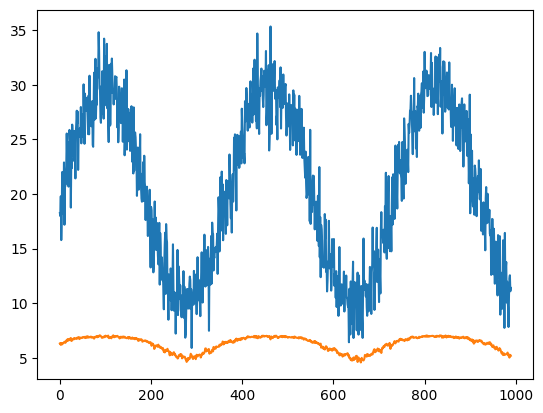

In [67]:
import matplotlib.pyplot as plt
plt.plot(labels)
plt.plot(predictions)
